# Figure 5

## Calling the packages

In [1]:
####importing packages
import sys
sys.path.append('/work/mh0731/m300876/package')
import icons
from pathlib import Path
import importlib
import numpy as np
import xarray as xr
import intake
import dask
from distributed import Client, progress, wait
import pandas as pd
from datetime import datetime

## Calling dask

In [2]:
icons.prepare_cpu(nworker=1,memory='256GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.120.253/2039319/1' processes=1 threads=256, memory=238.42 GiB>

## Setting functions

In [3]:
def read_file_top(files,times):
    ## This function extract the cloud top height data set
    ### file :  file of the data set
    ### times : [times_begin times_end] initial and last time of the analysis
    dataset = xr.open_mfdataset(files,
                        chunks={'time':1,'ncells':2621440*2}).sel(time=slice(times[0],times[1]))
    ## Masking data where cloud top height is lower than 0 masl
    dataset = dataset.where(dataset['cth']>0)
    return dataset

In [4]:
def read_file_base(files,times):
    ## This function extract the cloud base height data set
    ### file :  file of the data set
    ### times : [times_begin times_end] initial and last time of the analysis
    dataset = xr.open_mfdataset(files,
                        chunks={'time':1,'ncells':2621440*2}).sel(time=slice(times[0],times[1]))
    ## Masking data where cloud top height is higher than 99999 masl
    dataset = dataset.where(dataset['ctb']<99999)
    return dataset

In [5]:
def valid_cells(data,lat,lon,mask=None):
    ## This function select a region using latitude and longitude coordinates. A land-sea mask could be used.
    ### lat : [northward southward] The northernmost and southermost position
    ### lon : [westward eastward] The westernmost and easternmost position
    ### mask : default None (no use of a land-sea mask); use 0 to mask land (remove), 1 to mask ocean (remove) 
    if mask is not None:
        valid = (((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1])) & (data.land_sea_mask==mask)).values
    else:
        valid = (((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1]))).values
    return valid

In [6]:
def calculate_histogram(datarray,bins,width):
    ## This function calculate the histogram of a data
    hist = datarray.plot.hist(bins=bins,width=width,density=True)
    return hist

In [7]:
def histogram_clouds(files_top,files_base,times,
                     altitude_base=3000,lat=[-30,30],lon=[-180,180],
                     mask=None,bins=np.linspace(0,12400,32),width=200):
    ## This function calculate the histogram of the cloud top height
    ### files_top :  files conteining the cloud top height data 
    ### files_base :  files conteining the cloud base height data 
    ### times : [times_begin times_end] initial and last time of the analysis
    ### altitude_base :  the highest altitude of the base cloud
    ### lat : [northward southward] The northernmost and southermost position
    ### lon : [westward eastward] The westernmost and easternmost position
    ### mask : default None (no use of a land-sea mask); use 0 to mask land (remove), 1 to mask ocean (remove) 
    ### bins : bins to discretize cloud top heights
    ### width : width of the bars when plotting
    
    ## Extract cloud top height and cloud base height data
    top_cloud = read_file_top(files_top,times).cth
    base_cloud = read_file_base(files_base,times).ctb
    
    ## Selecting clouds with a cloud base below 3km
    top_cloud_3km = top_cloud.where(base_cloud<=altitude_base)
    
    ## Selecting clouds in a certain location
    valid = valid_cells(top_cloud,lat,lon,mask=None)
    ## Selecting clouds in a certain location and over ocean
    valid_o = valid_cells(top_cloud,lat,lon,mask=0)
    ## Selecting clouds in a certain location and over land
    valid_l = valid_cells(top_cloud,lat,lon,mask=1)
    
    ## Calculate the histograms cloud top height in the tropics
    hist_trop = calculate_histogram(top_cloud_3km.isel(ncells=valid),bins,width)
    ## Calculate the histograms cloud top height over tropical oceans
    hist_ocean = calculate_histogram(top_cloud_3km.isel(ncells=valid_o),bins,width)
    ## Calculate the histograms cloud top height over tropical continents
    hist_land = calculate_histogram(top_cloud_3km.isel(ncells=valid_l),bins,width)
    
    return hist_trop, hist_ocean, hist_land
    

## Computing

### Generate files

In [10]:
## files of cloud top height
filetop = '/work/mh0731/m300876/data/clouds/cloud_top_height_dpp0066_with_topo_20200201_202102028.nc'
## files of cloud base height
filebase = '/work/mh0731/m300876/data/clouds/cloud_base_height_dpp0066_with_topo_20200201_202102028.nc'
## times to analyze the data
times = ['2020-02-01','2021-01-31']

### Computing the histograms of cloud top height

CPU times: user 17min 24s, sys: 10min 11s, total: 27min 35s
Wall time: 20min 58s


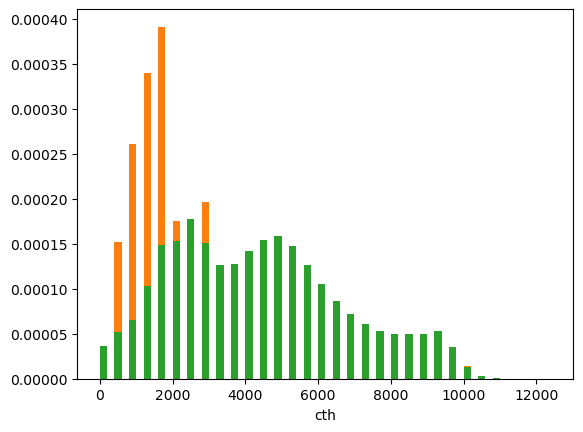

In [11]:
%%time 
hist_trop, histo_trop_o, hist_trop_l = histogram_clouds(filetop,filebase,times);

## Plotting

In [13]:
from matplotlib import pyplot as plt # Standard Plotting library
import seaborn as sns

### Figure 5

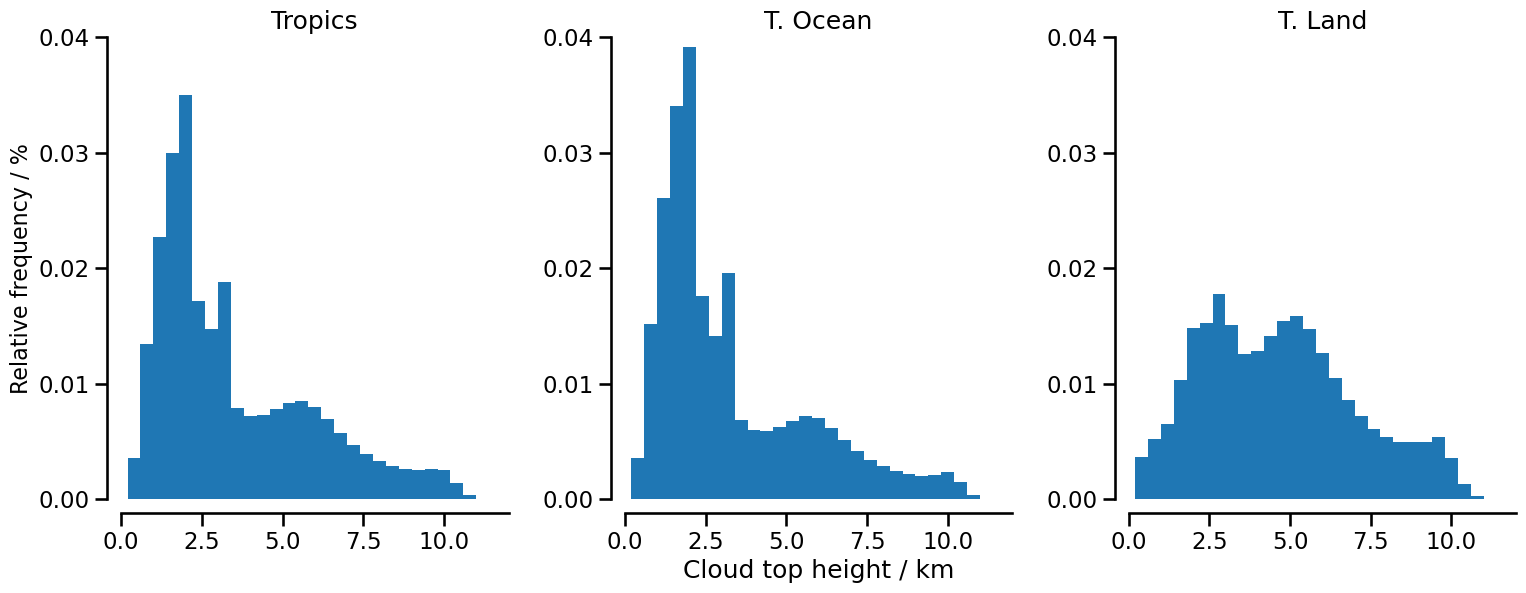

In [21]:
sns.set_context("talk")
fig1=plt.figure(figsize=(18,6),facecolor='white')
ax = fig1.add_subplot(1,3,1)
ax.bar((hist_trop[1][1:])/1000,hist_trop[0]*100,width=0.4)
ax.set_xlim([0,12]);ax.set_ylim([0,0.04])
ax.set_yticks(np.arange(0,0.041,0.01))
#ax.tick_params(labelsize=14)
#ax.set_xlabel('CTH - Kilometers',fontsize=14)
ax.set_ylabel('Relative frequency / %',fontsize=16)
ax.set_title('Tropics')

ax = fig1.add_subplot(1,3,2)
ax.bar((histo_trop_o[1][1:])/1000,histo_trop_o[0]*100,width=0.4)
ax.set_xlim([0,12]);ax.set_ylim([0,0.04])
ax.set_yticks(np.arange(0,0.041,0.01))
#ax.tick_params(labelsize=14)
ax.set_xlabel('Cloud top height / km')
#ax.set_ylabel('Relative frequency (%)',fontsize=14)
ax.set_title('T. Ocean')

ax = fig1.add_subplot(1,3,3)
ax.bar((hist_trop_l[1][1:])/1000,hist_trop_l[0]*100,width=0.4)
ax.set_xlim([0,12]);ax.set_ylim([0,0.04])
ax.set_yticks(np.arange(0,0.041,0.01))
#ax.tick_params(labelsize=14)
#ax.set_xlabel('CTH - Kilometers',fontsize=14)
#ax.set_ylabel('Relative frequency (%)',fontsize=14)
ax.set_title('T. Land')
plt.subplots_adjust(wspace=0.3)
sns.despine(offset=10)
plt.savefig('/scratch/m/m300876/results/clouds/histogram_CTH_dpp0066_202002_202101_tropics_ocean_land.png',dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})